## Baseline 6

##### 🔹Steps A and B: Same as in Baseline 3
- In Step B: Extract representations for each clip, consisting of 9 frames.
- Step C: Apply LSTM on the sequences from Step B
##### 🔹This model applies LSTM at the **image level only**


## Cloning the Repository

In [1]:
!rm -rf /kaggle/working/github
!git clone https://github.com/shehab-ashraf/Group-Activity-Recognition.git /kaggle/working/github
import sys
sys.path.append('/kaggle/working/github/')

Cloning into '/kaggle/working/github'...
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 201 (delta 2), reused 0 (delta 0), pack-reused 194 (from 1)
Receiving objects: 100% (201/201), 2.00 MiB | 21.97 MiB/s, done.
Resolving deltas: 100% (79/79), done.


## Importing Necessary Libraries

In [3]:
import os
import torch
from functools import partial
from torcheval.metrics import MulticlassAccuracy
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn.functional as F
import torch.optim as optim
from data_utils.dataloader import *
from data_utils.dataset import *
from Learner.learn import *
from models.BaseLine_6.model_a import *
from models.BaseLine_6.model_b import *
from helper_utils.helper import *

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Creating DataLoaders
 we create DataLoaders for train model_a to recognize players_actions

In [4]:
players_classes = ["waiting", "setting", "digging", "falling", "spiking", "blocking", "jumping", "moving", "standing"]
players_labels = {class_name:label for label, class_name in enumerate(players_classes)}


videos_path = '/kaggle/input/group-activity-recognition-volleyball/videos'
annot_path  = '/kaggle/input/group-activity-recognition-volleyball/annot_all.pkl'

train_videos = [1, 3, 6, 7, 10, 13, 15, 16, 18, 22, 23, 31, 32, 36, 38, 39, 40, 41, 42, 48, 50, 52, 53, 54]
valid_videos = [0, 2, 8, 12, 17, 19, 24, 26, 27, 28, 30, 33, 46, 49, 51]

transforms = A.Compose([
    A.Resize(224, 224),
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 5), p=0.3),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        A.ImageCompression(quality_lower=75, quality_upper=100, p=0.4),
    ], p=0.5),
    A.OneOf([
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=0.7),
        A.RandomBrightnessContrast(p=0.7),
    ], p=0.5),
    A.HorizontalFlip(p=0.03),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    ToTensorV2()
])

dls = create_dataloader(
    videos_path=videos_path,
    annot_path=annot_path,
    labels=players_labels,
    train_split=train_videos,
    valid_split=valid_videos,
    train_transforms=transforms,
    mode="player_level",
    only_middle_frame=True,
    batch_size=32,
    num_workers=0
)

## Check DataSet
see if data is prepared as we want

In [5]:
len(dls.train), len(dls.valid)

(804, 500)

## Setting Up Training Callbacks
we define training callbacks including:<br>
MetricsCB: For tracking accuracy<br>
TrainCB: General training utilities<br>
ProgressCB: Visualizing training progress<br>
DeviceCB: Ensuring correct device allocation<br>
we then initialize the Learner class and try to find an good learning-rate.

In [7]:
cbs = [
    OptimizerCB(partial(optim.AdamW)),
    MetricsCB(accuracy=MulticlassAccuracy()),
    TrainCB(), 
    ProgressCB(plot=False), 
    DeviceCB(),
]

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]


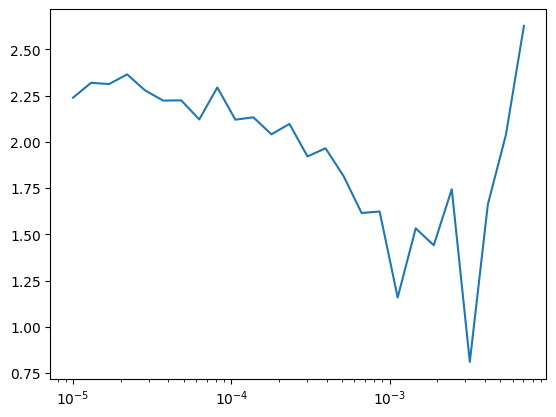

In [8]:
Person_Activity_Model = Player_Activity_Classifier(9)
learn = Learner(Person_Activity_Model, dls, loss_func=F.cross_entropy, cbs=cbs)
learn.lr_find()

## Training Model_a
we train the model_a using the AdamW optimizer and OneCycleLR scheduler for 5 epochs.

In [9]:
lr,epochs = 5e-4,5
cbs = [
    OptimizerCB(partial(optim.AdamW, weight_decay=1e-6)),
    BatchSchedCB(partial(OneCycleLR, 
        max_lr=lr,
        epochs=5,
        steps_per_epoch=len(dls.train),
        pct_start=0.3,
        div_factor=25,
        final_div_factor=1e2
    )),
    MetricsCB(accuracy=MulticlassAccuracy()),
    TrainCB(), 
    ProgressCB(plot=False), 
    DeviceCB(),
]
Person_Activity_Model = Player_Activity_Classifier(9)
person_activity_learner = Learner(Person_Activity_Model, dls, loss_func=F.cross_entropy, cbs=cbs) 
torch.cuda.empty_cache()
person_activity_learner.fit(n_epochs=epochs, lr=lr/25)

accuracy,loss,epoch,train
0.669,1.088,0,train
0.729,0.898,0,eval
0.766,0.709,1,train
0.762,0.729,1,eval
0.806,0.567,2,train
0.787,0.639,2,eval
0.862,0.386,3,train
0.799,0.636,3,eval
0.941,0.186,4,train
0.801,0.649,4,eval


## Creating DataLoaders
 we create DataLoaders for train model_b to recognize group_activity

In [11]:
group_classes = ['l-pass', 'r-pass', 'l_set', 'r_set' ,'l-spike', 'r_spike', 'l_winpoint', 'r_winpoint']
group_labels = {groub_class:label for label, groub_class in enumerate(group_classes)}

videos_path = '/kaggle/input/group-activity-recognition-volleyball/videos'
annot_path  = '/kaggle/input/group-activity-recognition-volleyball/annot_all.pkl'

train_videos = [1, 3, 6, 7, 10, 13, 15, 16, 18, 22, 23, 31, 32, 36, 38, 39, 40, 41, 42, 48, 50, 52, 53, 54]
valid_videos = [0, 2, 8, 12, 17, 19, 24, 26, 27, 28, 30, 33, 46, 49, 51]

transforms = A.Compose([
    A.Resize(224, 224),
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 5), p=0.3),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        A.ImageCompression(quality_lower=75, quality_upper=100, p=0.4),
    ], p=0.5),
    A.OneOf([
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=0.7),
        A.RandomBrightnessContrast(p=0.7),
    ], p=0.5),
    A.HorizontalFlip(p=0.03),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    ToTensorV2()
])

dls = create_dataloader(
    videos_path=videos_path,
    annot_path=annot_path,
    labels=group_labels,
    train_split=train_videos,
    valid_split=valid_videos,
    train_transforms=transforms,
    mode="image_level",
    seq=True,
    crop=True,
    only_middle_frame=False,
    batch_size=8,
    num_workers=4
)

## Check DataSet
see if data is prepared as we want

In [12]:
len(dls.train), len(dls.valid)

(269, 168)

In [13]:
it = iter(dls.train)
next(it)[0].shape

torch.Size([8, 9, 12, 3, 224, 224])

## Setting Up Training Callbacks
we define training callbacks including:<br>
MetricsCB: For tracking accuracy<br>
TrainCB: General training utilities<br>
ProgressCB: Visualizing training progress<br>
DeviceCB: Ensuring correct device allocation<br>
we then initialize the Learner class and try to find an good learning-rate.

In [14]:
cbs = [
    OptimizerCB(partial(optim.AdamW)),
    MetricsCB(accuracy=MulticlassAccuracy()),
    MixedPrecisionCB(), 
    ProgressCB(plot=False), 
    DeviceCB(),
]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


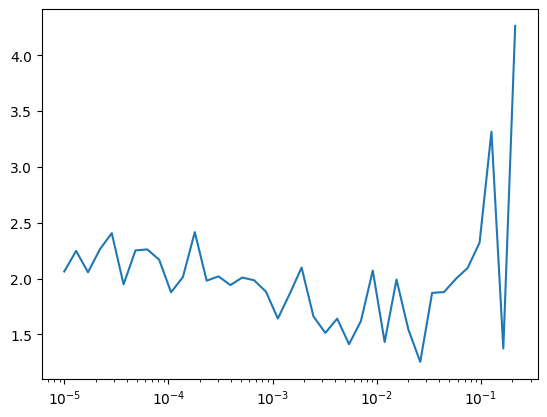

In [16]:
Person_Activity_Model.eval()
Group_Activity_Model = Group_Activity_Classifer(Person_Activity_Model)
Group_Activity_Learner = Learner(model=Group_Activity_Model, dls=dls, loss_func=F.cross_entropy, cbs=cbs)
Group_Activity_Learner.lr_find()

## Training Model_b

In [17]:
lr,epochs = 8e-4,10
cbs = [
    OptimizerCB(partial(optim.AdamW,  weight_decay=0.0001)),
    BatchSchedCB(partial(OneCycleLR, 
        max_lr=lr,
        epochs=epochs,
        steps_per_epoch=len(dls.train),
        pct_start=0.3,
        div_factor=25,
        final_div_factor=1e4
    )),
    MetricsCB(accuracy=MulticlassAccuracy()),
    MixedPrecisionCB(),
    ProgressCB(plot=False), 
    DeviceCB(),
]
Group_Activity_Model = Group_Activity_Classifer(Person_Activity_Model)
Group_Activity_Learner = Learner(model=Group_Activity_Model, dls=dls, loss_func=F.cross_entropy, cbs=cbs)
Group_Activity_Learner.fit(n_epochs=epochs, lr=lr/25)

accuracy,loss,epoch,train
0.435,1.620,0,train
0.581,1.292,0,eval
0.689,1.001,1,train
0.579,1.182,1,eval
0.720,0.806,2,train
0.385,1.912,2,eval
0.728,0.768,3,train
0.495,1.760,3,eval
0.790,0.596,4,train
0.708,0.805,4,eval


## Testing
#### We are currently evaluating our model by performing a single iteration over the test_data.

In [18]:
test_videos = [4, 5, 9, 11, 14, 20, 21, 25, 29, 34, 35, 37, 43, 44, 45, 47]
test_dataloader = create_dataloader(
    videos_path=videos_path,
    annot_path=annot_path,
    labels=group_labels,
    train_split=[],
    valid_split=test_videos,
    mode="image_level",
    seq=True,
    crop=True,
    only_middle_frame = False,
    batch_size=8,
    num_workers=4
)

accuracy,loss,epoch,train
0.830,0.459,0,eval


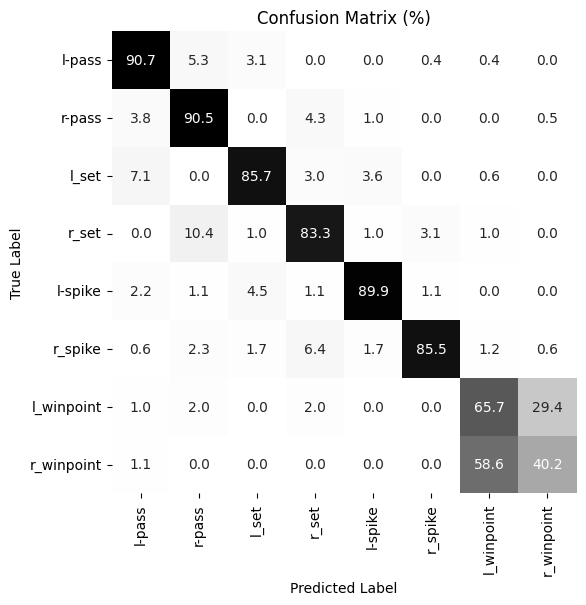

In [19]:
confusion_matrix_cb = ConfusionMatrixCB(class_names=group_classes)
cbs=[TrainCB(), ProgressCB(plot=False), DeviceCB(), confusion_matrix_cb, MetricsCB(accuracy=MulticlassAccuracy())] 
Group_Activity_Model.eval()
Group_Activity_Learner = Learner(model=Group_Activity_Model, dls=test_dataloader, loss_func=F.cross_entropy, cbs=cbs)
torch.cuda.empty_cache()
Group_Activity_Learner.fit(1, train=False)